# Inspect the GP parameters


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import corner
import arviz as az
import xarray as xr

/opt/tljh/user/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
# samples_az.to_netcdf('../DATA/swot_nadir_GP_mesoitide_samples_v1.nc')
# priors_out_az.to_netcdf('../DATA/swot_nadir_GP_mesoitide_priors_v1.nc')
samples_az = xr.open_dataset('../DATA/swot_nadir_GP_mesoitide_samples_v2.nc')
priors_out_az = xr.open_dataset('../DATA/swot_nadir_GP_mesoitide_priors_v2.nc')


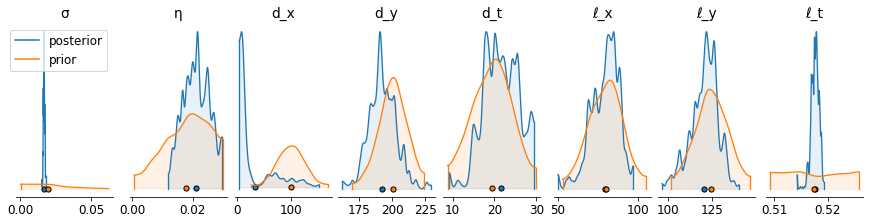

In [3]:

labels = ['σ','η','d_x','d_y','d_t','ℓ_x', 'ℓ_y','ℓ_t',]


axs = az.plot_density(   [samples_az[labels],
                         priors_out_az[labels]],
                         shade=0.1,
                         grid=(1, 8),
                         textsize=12,
                         figsize=(12,3),
                         data_labels=('posterior','prior'),
                         hdi_prob=0.995)

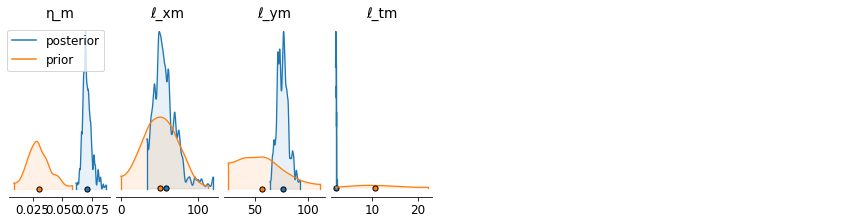

In [4]:
labels = ['η_m','ℓ_xm','ℓ_ym','ℓ_tm']

axs = az.plot_density(   [samples_az[labels],
                         priors_out_az[labels]],
                         shade=0.1,
                         grid=(1, 8),
                         textsize=12,
                         figsize=(12,3),
                         data_labels=('posterior','prior'),
                         hdi_prob=0.995)

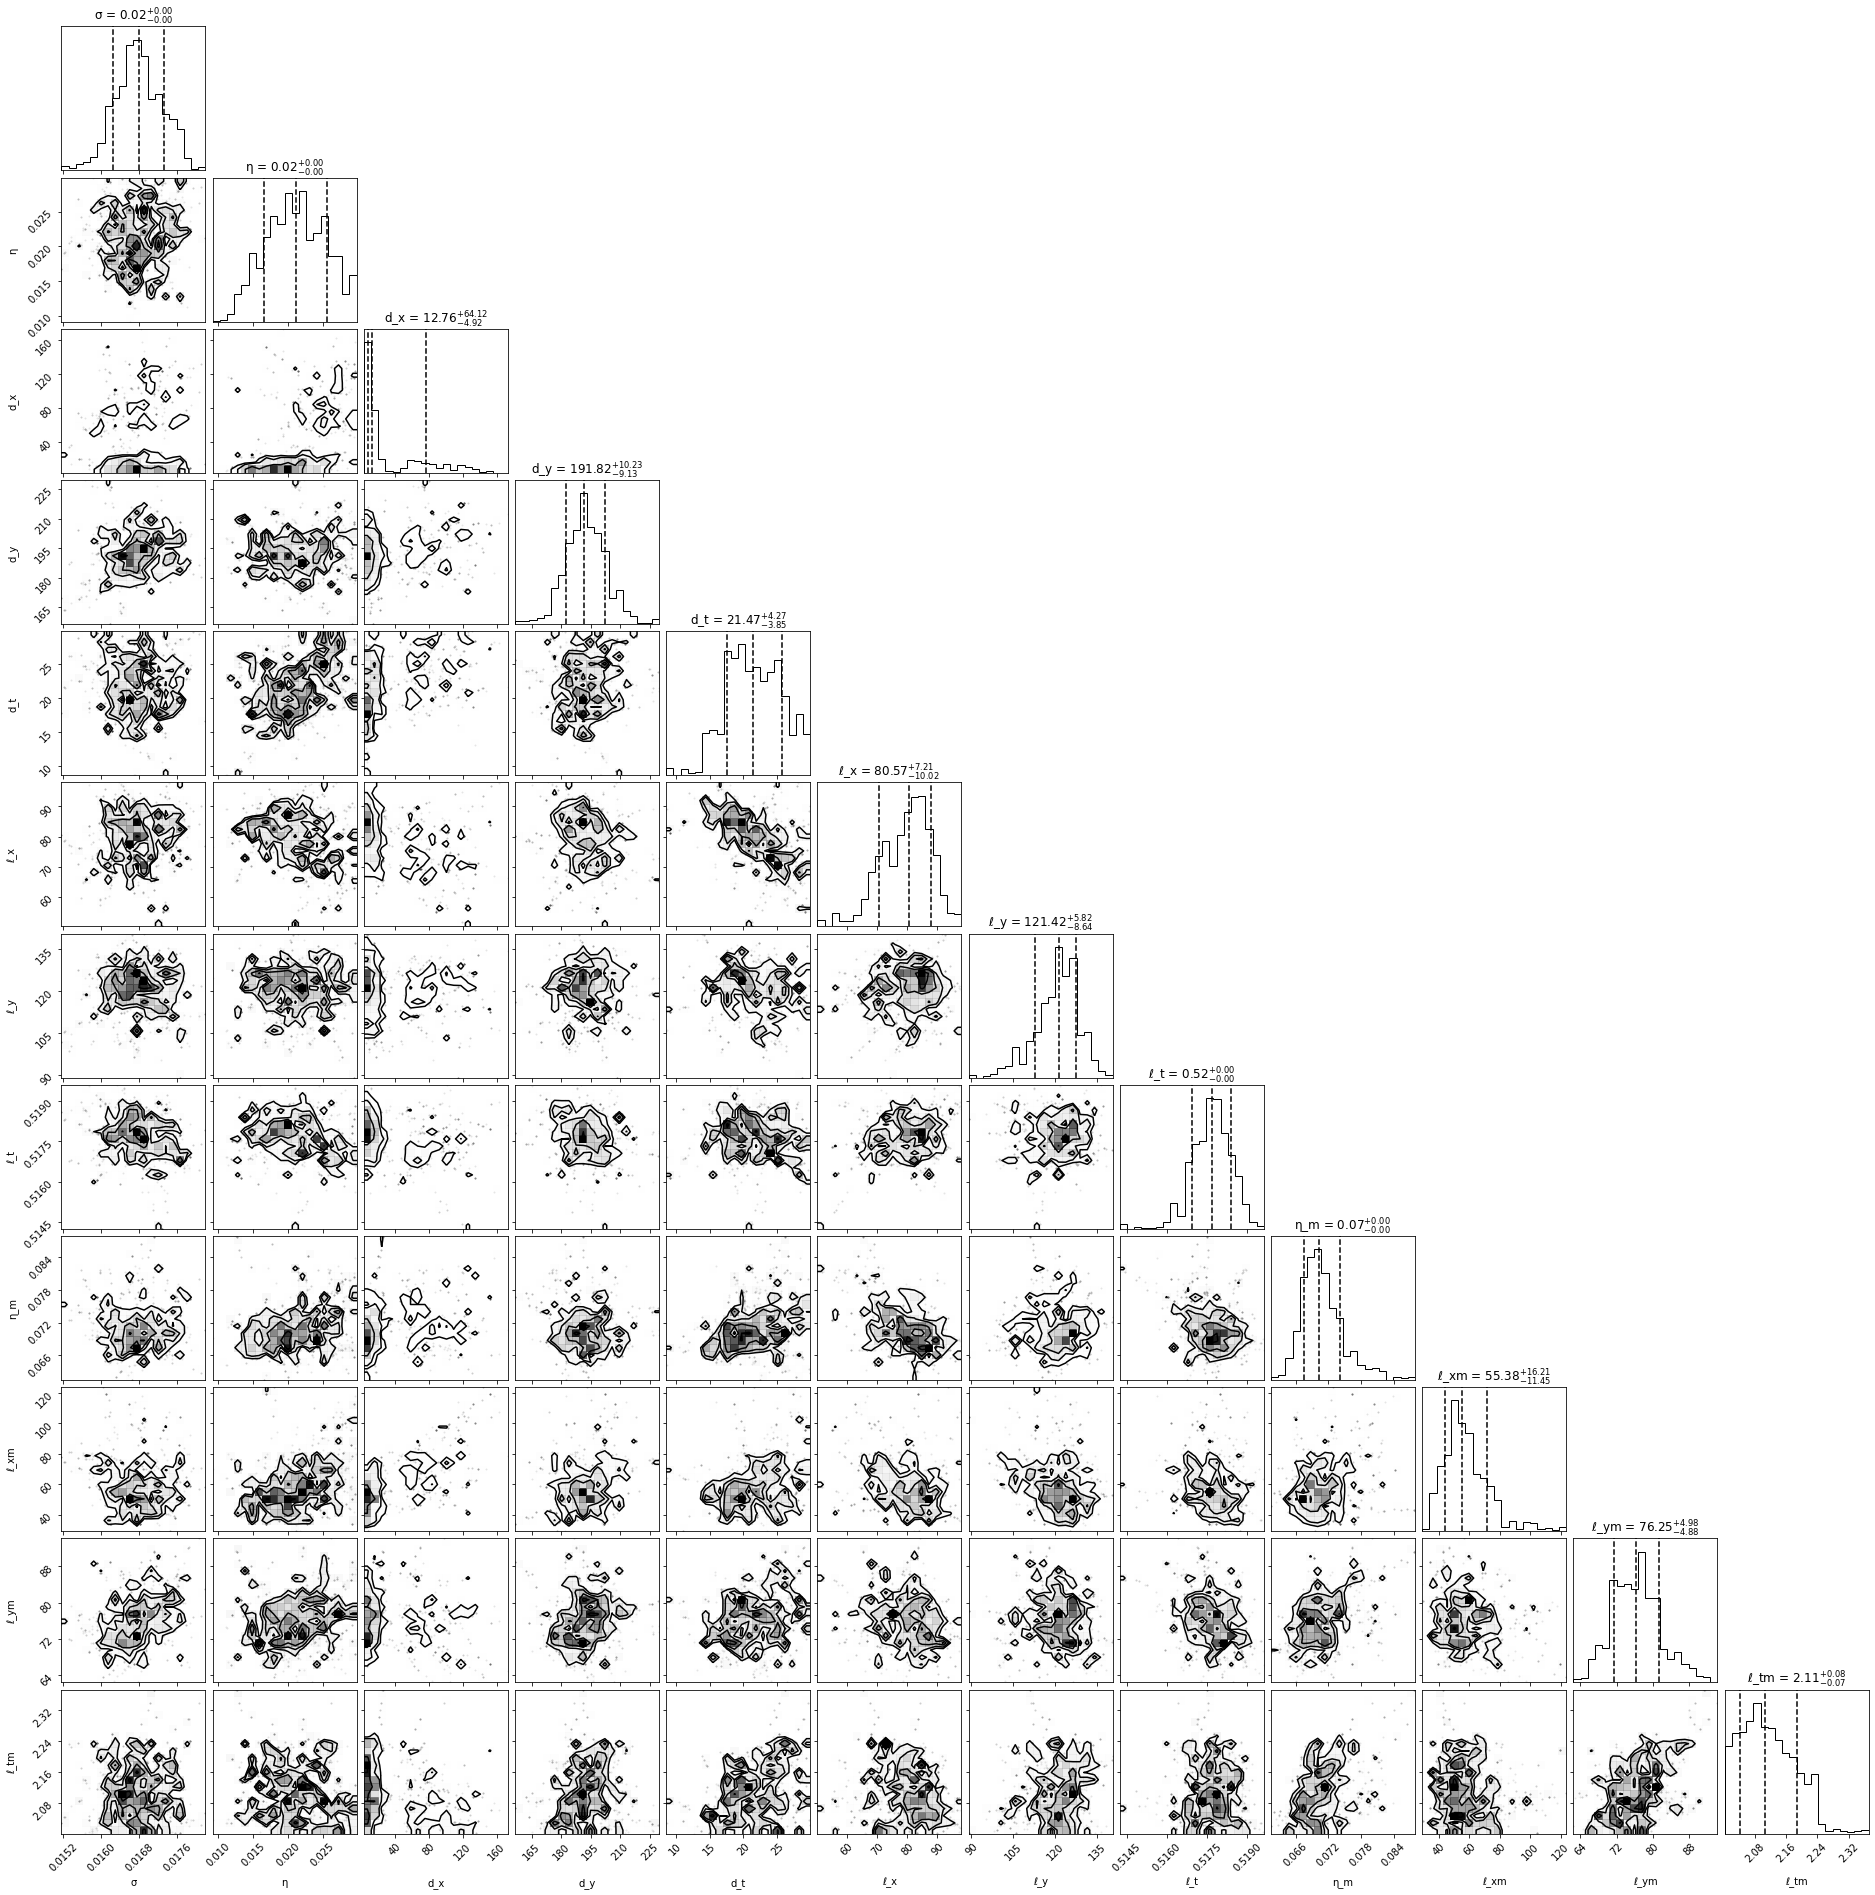

In [5]:
labels = ['σ','η','d_x','d_y','d_t','ℓ_x', 'ℓ_y','ℓ_t','η_m','ℓ_xm','ℓ_ym','ℓ_tm']

fig = corner.corner(samples_az,
                    show_titles=True,
                    labels=labels,
                    plot_datapoints=True,
                    quantiles=[0.16, 0.5, 0.84])



In [6]:
# Generate a new prior with these parameters
covparams = [samples_az[ll].values.mean() for ll in labels[1:]]
noise_params = [samples_az[ll].values.mean() for ll in labels[0]][0]
noise_params, covparams

(0.016774713065967718,
 [0.0211019595308208,
  33.84552982593093,
  192.47088213918119,
  21.60212354754097,
  79.38897912770857,
  120.40209682321316,
  0.517641095075333,
  0.07088082291538417,
  58.00326126530253,
  76.29353474497339,
  2.1130252750601954])

In [7]:
from sfoda.utils.myproj import MyProj

#swot = xr.open_dataset('/data-obs/jupyter-ubuntu/SWOT/SWOT_nadir_BrowseBasin_MarApr2023.nc')
#swot = xr.open_dataset('/data-obs/jupyter-ubuntu/SWOT/SWOT_nadir_BrowseBasin_MarApr2023_w_iwatlas.nc')
swot = xr.open_dataset('/data-obs/jupyter-ubuntu/SWOT/SWOT_nadir_BrowseBasin_MarJun2023_v2.nc')

# swot = xr.open_dataset('/data-obs/jupyter-ubuntu/SWOT/SWOT_nadir_BrowseBasin_MarJun2023_w_iwatlas.nc')

P = MyProj(None, utmzone=51, isnorth=False)
x,y = P.to_xy(swot.longitude.values, swot.latitude.values)

xpr, ypr = (x-x.mean())/1000, (y-y.mean())/1000

t = swot.time - swot.time[0]

tpr = t.values.astype(float)/1e9/86400.

XYT = np.array([xpr, ypr, tpr]).T
XYT.shape

(2027, 3)

In [8]:
from gptide import cov
from gptide import GPtideScipy
from scipy import stats
from gptide import stats as gpstats

def oscillate_1d(x, xpr, params, itfunc=cov.matern12):
    """
    1D Oscillatory kernel
    """
    eta, d, l = params
    
    return eta**2 * itfunc(x, xpr, d) * cov.cosine(x, xpr, l)

def K_itide_3d(x, xpr, params, **kwargs):
    eta, dx, dy, dt, lx, ly, lt = params

    # Build the covariance matrix
    C  = oscillate_1d(x[:,0,None], xpr.T[:,0,None].T, (1, dx, lx), **kwargs)
    C  *= oscillate_1d(x[:,1,None], xpr.T[:,1,None].T, (1, dy, ly), **kwargs)
    C  *= oscillate_1d(x[:,2,None], xpr.T[:,2,None].T, (1, dt, lt), **kwargs)
    C *= eta**2

    return C

def K_meso_3d(x, xpr, params, mesofunc=cov.matern32):
    eta, lx, ly, lt = params

    # Build the covariance matrix
    C  = mesofunc(x[:,0,None], xpr.T[:,0,None].T, lx)
    C  *= mesofunc(x[:,1,None], xpr.T[:,1,None].T, ly)
    C  *= mesofunc(x[:,2,None], xpr.T[:,2,None].T, lt)
    C *= eta**2

    return C

def K_meso_it(x, xpr, params, mesofunc=cov.matern32, itfunc=cov.matern32):
    eta_i, dx_i, dy_i, dt_i, lx_i, ly_i, lt_i, eta_m, lx_m, ly_m, lt_m = params
    
    K = K_itide_3d(x, xpr, (eta_i, dx_i, dy_i, dt_i, lx_i, ly_i, lt_i), itfunc=itfunc)
    K += K_meso_3d(x, xpr, (eta_m, lx_m, ly_m, lt_m), mesofunc=mesofunc)
    return K

(array([19431., 19448., 19462., 19478., 19492., 19509., 19523.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

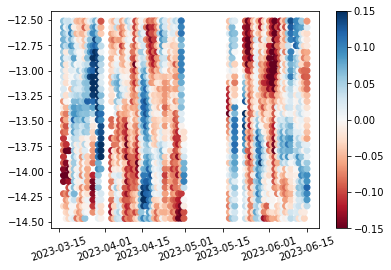

In [9]:
covfunc = K_meso_it
cov_kwargs = {}
#####


GP = GPtideScipy(XYT, XYT.copy(), noise_params, covfunc, covparams, cov_kwargs=cov_kwargs)

# Use the .prior() method to obtain some samples
zd = GP.prior(samples=1)

plt.figure()
plt.scatter(swot.time.values, swot.latitude.values, c=zd.ravel(), cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.xticks(rotation=18)

# Make a prediction at one site

In [10]:
%matplotlib notebook

<IPython.core.display.Javascript object>


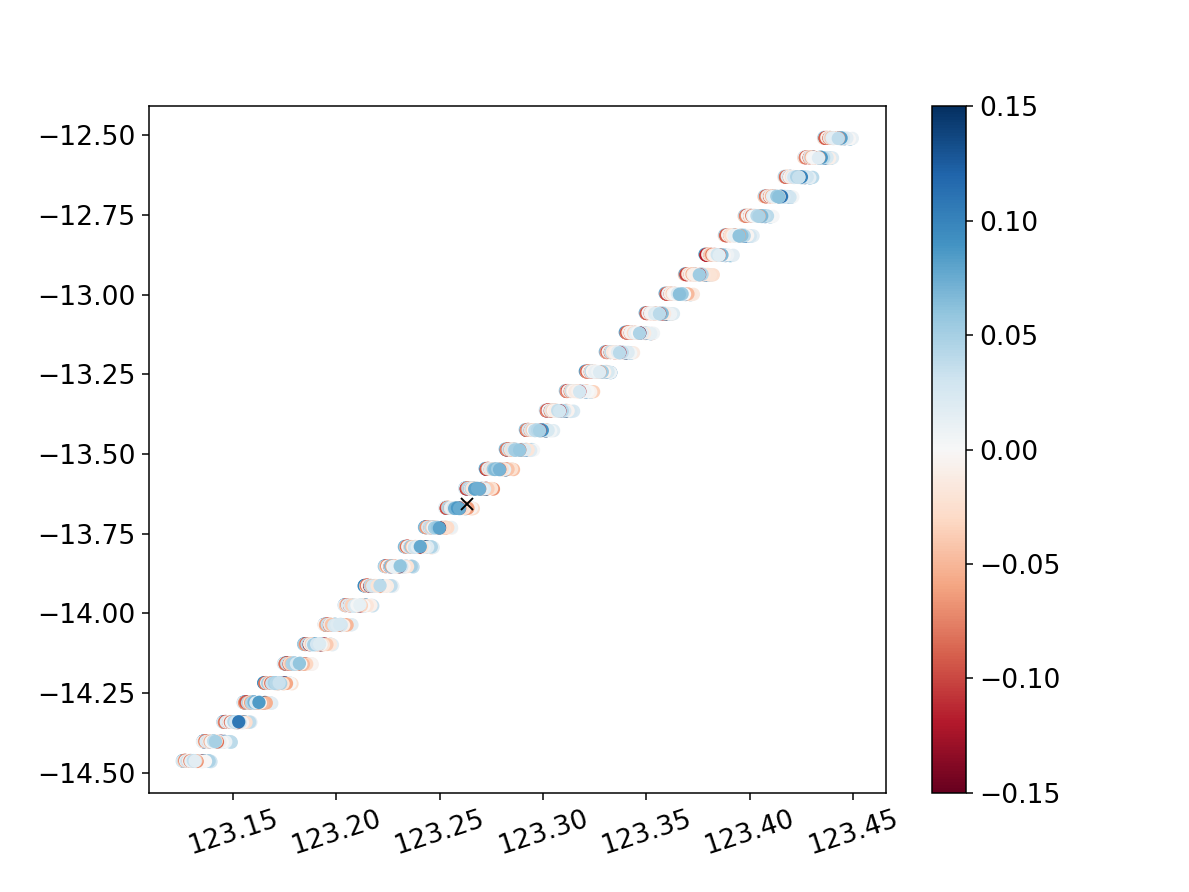

In [30]:
yd = swot['sla_unfiltered'].values-swot['sla_unfiltered'].values.mean()


plt.figure()
plt.scatter(swot.longitude.values, swot.latitude.values, c=yd, cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.xticks(rotation=18)

lonsite, latsite = 123.263, -13.657
# lonsite, latsite =123.16, -14.27

plt.plot(lonsite, latsite, 'kx')

<IPython.core.display.Javascript object>


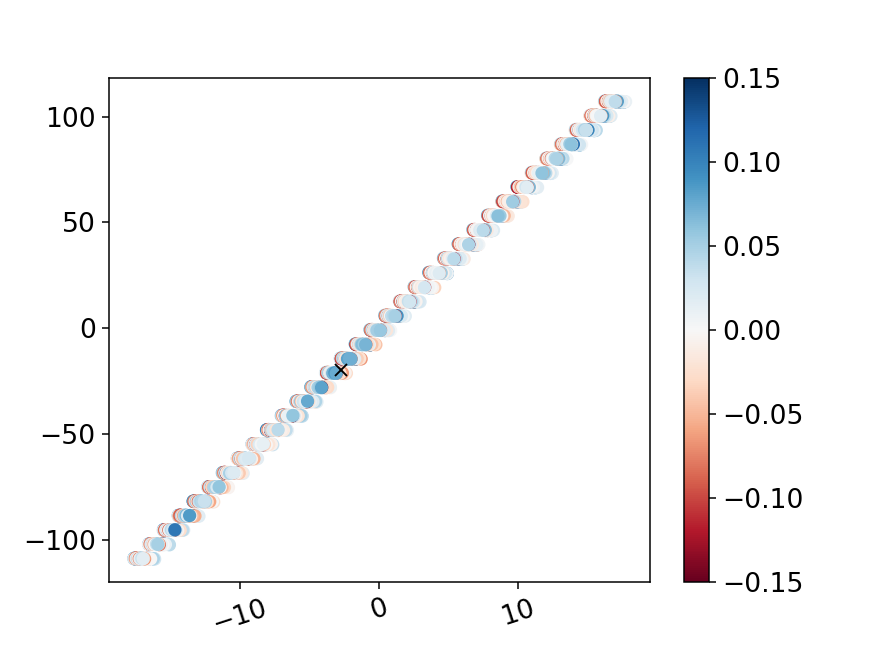

In [31]:

xsite,ysite = P.to_xy(lonsite, latsite)
xsitepr, ysitepr = (xsite-x.mean())/1000, (ysite-y.mean())/1000

plt.figure()
plt.scatter(xpr, ypr, c=yd, cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.xticks(rotation=18)

plt.plot(xsitepr, ysitepr, 'kx')

<IPython.core.display.Javascript object>


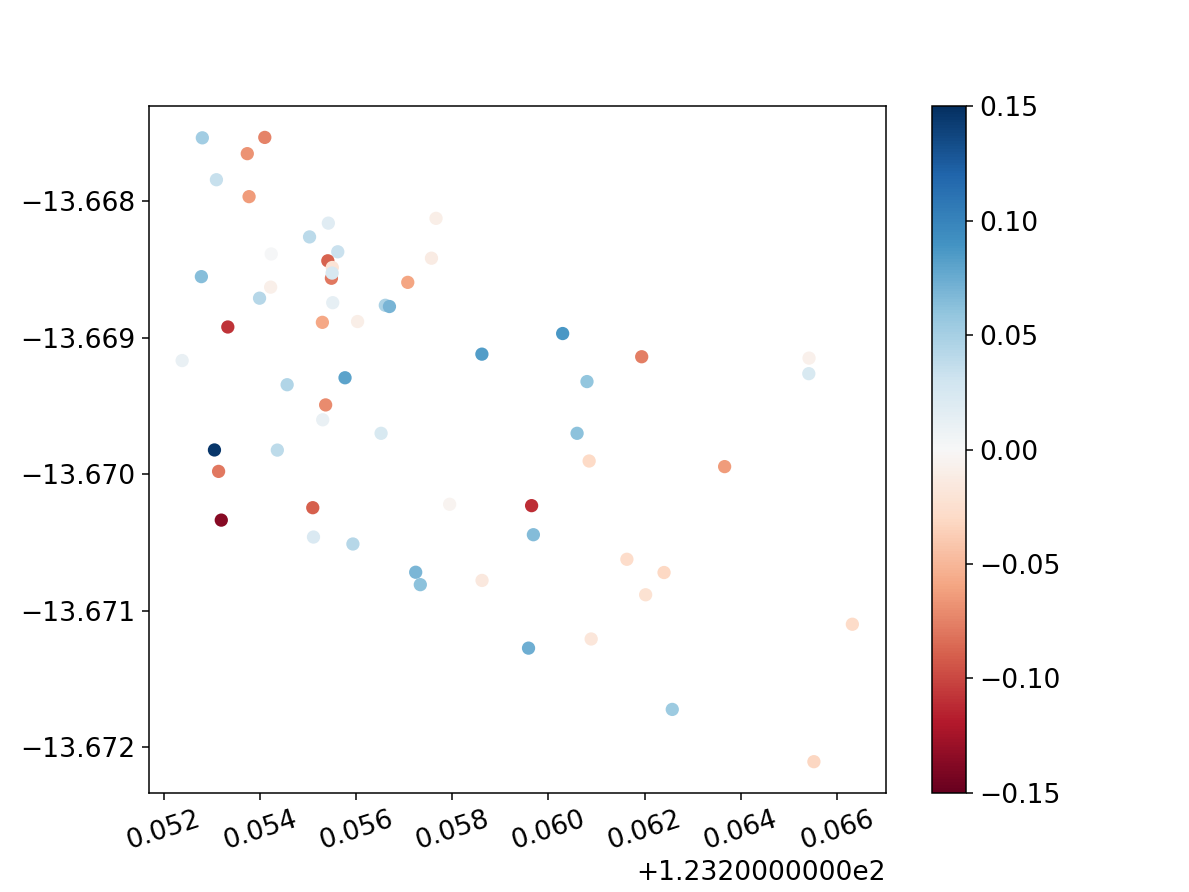

<xarray.Dataset>
Dimensions:                    (time: 61)
Coordinates:
  * time                       (time) datetime64[ns] 2023-03-16T17:27:24.5303...
    longitude                  (time) float64 123.3 123.3 123.3 ... 123.3 123.3
    latitude                   (time) float64 -13.67 -13.67 ... -13.67 -13.67
Data variables:
    longitude_theoretical      (time) float64 123.3 123.3 123.3 ... 123.3 123.3
    latitude_theoretical       (time) float64 -13.67 -13.67 ... -13.67 -13.67
    distance_from_theoretical  (time) float64 0.5607 0.6038 ... 0.4224 0.5836
    cycle                      (time) float64 461.0 464.0 465.0 ... 551.0 552.0
    track                      (time) float64 21.0 21.0 21.0 ... 21.0 21.0 21.0
    sla_unfiltered             (time) float32 0.199 0.222 0.196 ... 0.218 0.208
    dac                        (time) float32 0.0 0.02 0.028 ... -0.019 -0.039
    ib_lf                      (time) float32 0.016 0.02 0.023 ... -0.018 -0.018
    ocean_tide                 (time) float32 -0.345 -0.209 ... -0.385 0.221
    internal_tide              (time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mdt                        (time) float32 1.019 1.019 1.019 ... 1.02 1.019
    flag                       (time) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by altimeter...
    contact:                         aviso@altimetry.fr
    creator_email:                   aviso@altimetry.fr
    ...                              ...
    summary:                         SSALTO/DUACS Near-Real-Time Level-3 sea ...
    time_coverage_duration:          P23H51M44.812667S
    time_coverage_end:               2023-03-16T23:59:58Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2023-03-16T00:08:13Z
    title:                           NRT SWOT nadir 1day Global Ocean Along t...

In [32]:
dist = xr.DataArray(np.abs( (xsitepr-xpr) + 1J*(ysitepr-ypr)), dims=('time',) ,coords={
    'time':swot.time})

dist_cutoff = 2.
swotsite = swot.where(dist<dist_cutoff,  drop=True)

ydsite = swotsite['sla_unfiltered'].values-swotsite['sla_unfiltered'].values.mean()

plt.figure()
plt.scatter(swotsite.longitude.values, swotsite.latitude.values, c=ydsite, cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.colorbar()
plt.xticks(rotation=18)

# plt.plot(xsitepr, ysitepr, 'kx')
swotsite

In [33]:
# Create the coordinates
tlength = swot.time[-1]-swot.time[0]
dt = 3600
steps = (tlength.values.astype(float)*1e-9/dt).astype(int)

tout = np.arange(0,steps/24, 1/24)
timeout = np.array([swot.time.values[0] + np.timedelta64(int(tt*86400),'s') for tt in tout])

xout = xsitepr*np.ones_like(tout)
yout = ysitepr*np.ones_like(tout)

XYTout = np.array([xout, yout, tout]).T


In [34]:
XYT.shape, XYTout.shape

((2027, 3), (2169, 3))

In [35]:
%%time
GP = GPtideScipy(XYT, XYTout, noise_params, covfunc, covparams, cov_kwargs=cov_kwargs)

ssh_pred = GP(yd)
ssh_pred = GP.conditional(yd[:,None], samples=50)

CPU times: user 4.68 s, sys: 920 ms, total: 5.6 s
Wall time: 3.96 s


<IPython.core.display.Javascript object>


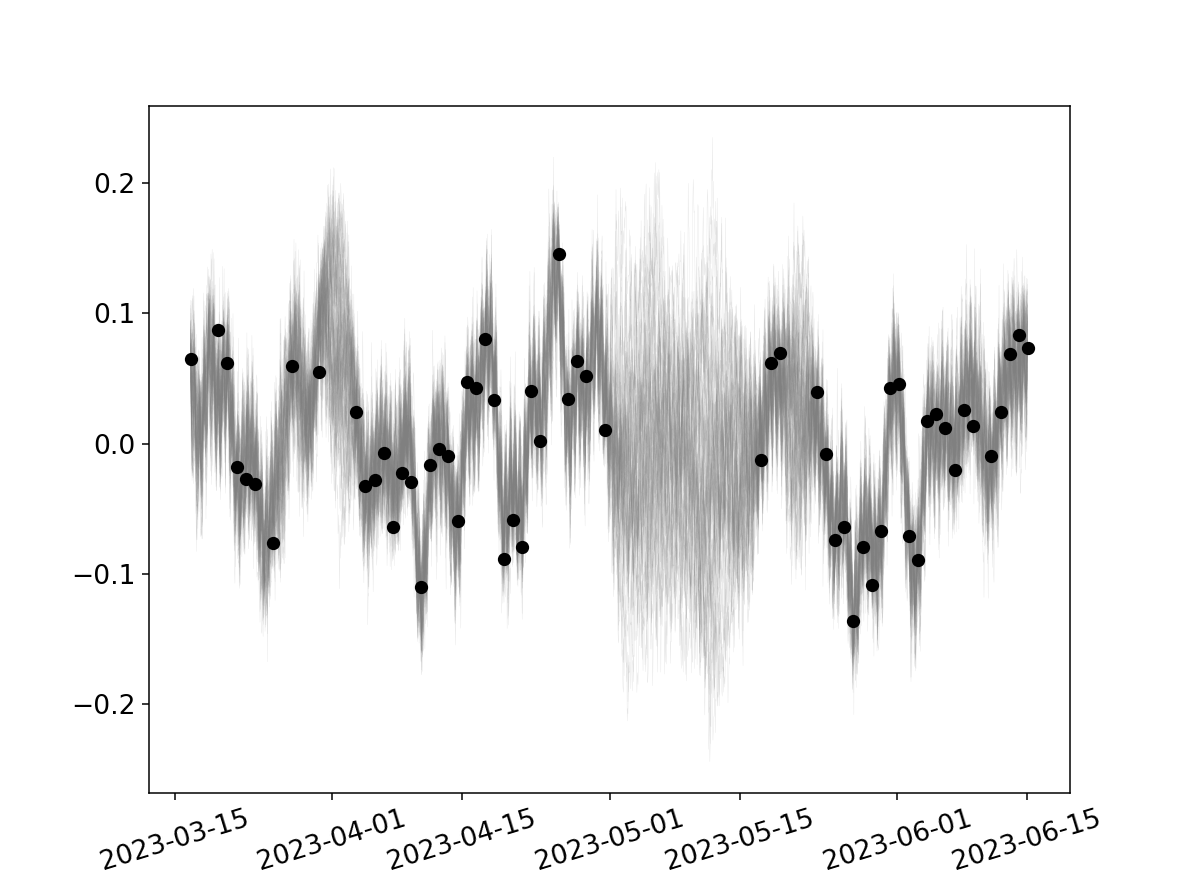

In [36]:
plt.figure()
plt.plot(timeout, ssh_pred,'0.5', lw=0.2, alpha=0.2)
plt.plot(swotsite.time, ydsite,'ko')

_ = plt.xticks(rotation=17)

In [38]:
# These are the sub-modules in the iwatlas package that we will use
from iwatlas import sshdriver
from iwatlas import harmonics

basedir = '/data-obs/jupyter-ubuntu/iwatlas'
atlasfile = '{}/NWS_2km_GLORYS_hex_2013_2014_InternalWave_Atlas.nc'.format(basedir)

ssh = sshdriver.load_ssh_clim(atlasfile)
ssh

<xarray.Dataset>
Dimensions:     (Nc: 225368, numsides: 8, Np: 454016, Nmode: 4, Nk: 80, Nkw: 81, Nannual: 4, Nparams: 7, Ntide: 35)
Coordinates:
    xv          (Nc) float64 ...
    yv          (Nc) float64 ...
    Nk          (Nc) int32 74 76 76 75 73 74 77 76 ... 79 79 79 79 79 79 79 79
    z_w         (Nkw) float64 ...
    omegaA      (Nannual) float64 ...
    params      (Nparams) int64 ...
    omega       (Ntide) float64 ...
Dimensions without coordinates: Nc, numsides, Np, Nmode, Nkw, Nannual, Nparams, Ntide
Data variables: (12/15)
    cells       (Nc, numsides) int32 3058 3061 3060 2801 ... 316184 316187 -1 -1
    xp          (Np) float64 1.394e+07 1.271e+07 ... 1.303e+07 1.303e+07
    yp          (Np) float64 -1.619e+06 -2.553e+06 ... -2.056e+06 -2.055e+06
    nfaces      (Nc) int32 ...
    dv          (Nc) float64 ...
    modes       (Nmode) float64 ...
    ...          ...
    N2_re       (Nannual, Nparams, Nc) float64 ...
    N2_im       (Nannual, Nparams, Nc) float64 ...
 

In [39]:
aa, Aa, Ba, frq = sshdriver.extract_hc_ssh(ssh, lonsite, latsite)
ssh_it = sshdriver.predict_scalar(timeout, aa, Aa, Ba, frq)


<IPython.core.display.Javascript object>


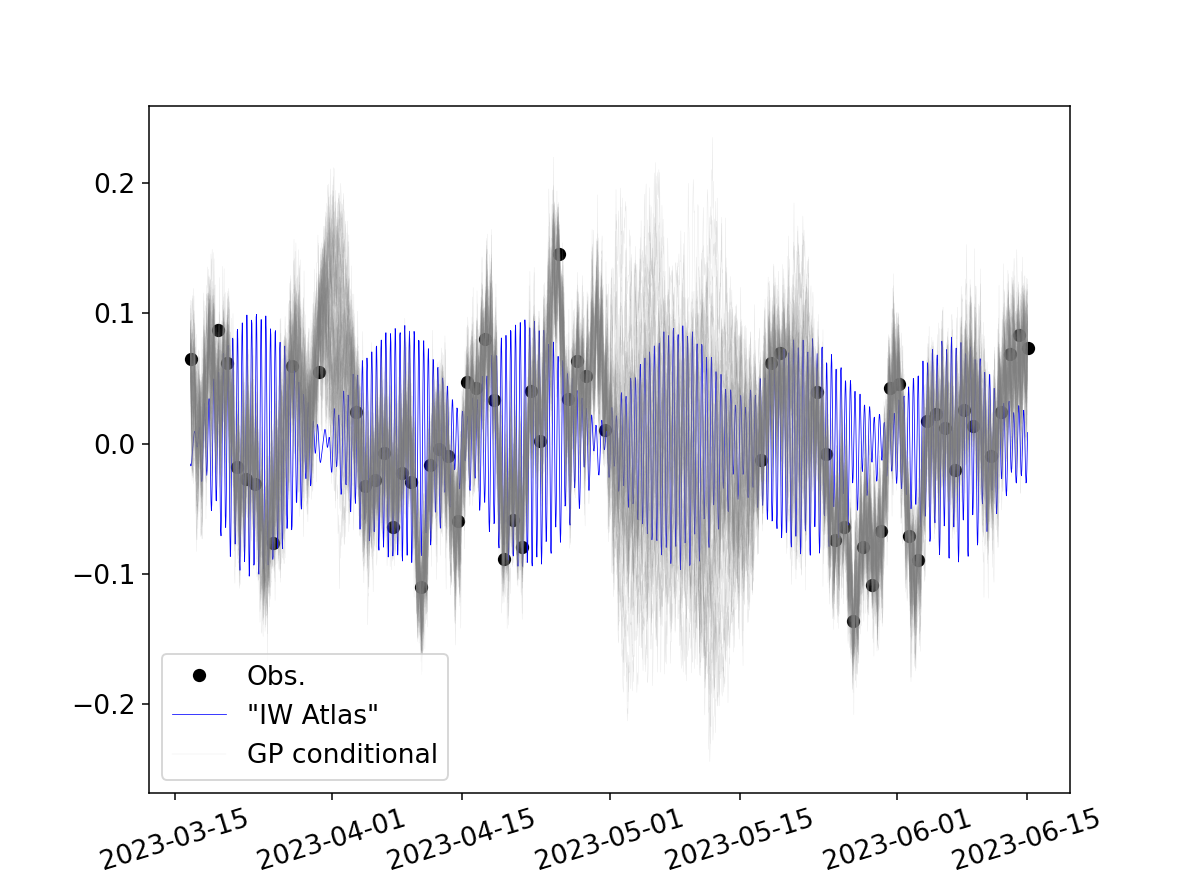

In [40]:
plt.figure()
plt.plot(swotsite.time, ydsite,'ko')
plt.plot(timeout, ssh_it,'b', lw=0.4)
plt.plot(timeout, ssh_pred,'0.5', lw=0.2,alpha=0.2)

_ = plt.xticks(rotation=17)

plt.legend(('Obs.','"IW Atlas"','GP conditional',))

In [47]:
%%time

#noise_params_guess = 0.006240057948674139
noise_params_guess = 0.016774713065967718
cov_params_guess =  [0.0211019595308208,
  #33.84552982593093, #l_xi
  200,
  192.47088213918119,
  #21.60212354754097, #l_ti
  10.,                     
  79.38897912770857,
  120.40209682321316,
  0.517641095075333,
  0.07088082291538417,
  58.00326126530253,
  76.29353474497339,
  #2.1130252750601954 # l_tm
  20.,
    ]
                   

GP = GPtideScipy(XYT, XYTout, noise_params_guess, covfunc, cov_params_guess, cov_kwargs=cov_kwargs)

ssh_pred = GP(yd)
ssh_pred = GP.conditional(yd[:,None], samples=50)

CPU times: user 4.71 s, sys: 1.23 s, total: 5.94 s
Wall time: 4.11 s


<IPython.core.display.Javascript object>


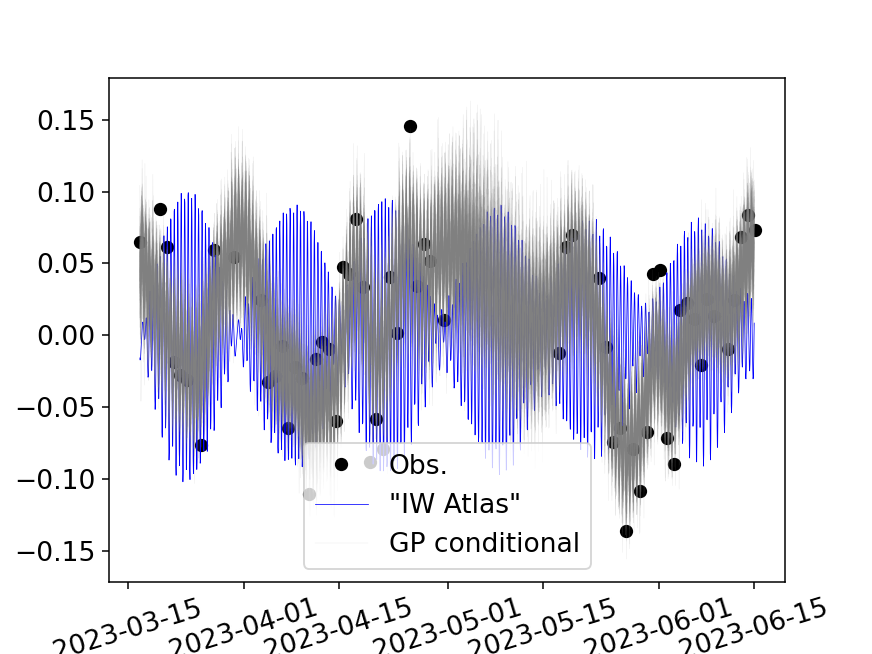

In [48]:
plt.figure()
plt.plot(swotsite.time, ydsite,'ko')
plt.plot(timeout, ssh_it,'b', lw=0.4)
plt.plot(timeout, ssh_pred,'0.5', lw=0.2,alpha=0.2)

_ = plt.xticks(rotation=17)

plt.legend(('Obs.','"IW Atlas"','GP conditional',))

## Some ideas for next steps:
 
 1. Compare these results with the mooring steric height estimates
 2. Compute some of the time/length scales from the SUNTANS 12-month data
 3. Test BlackJax sampler
 

In [33]:
from gptide import GPtideJax

In [38]:
# %%time
# GP = GPtideJax(XYT, XYTout, noise_params_guess, covfunc, cov_params_guess, cov_kwargs=cov_kwargs)

# ssh_pred = GP(swot.ssh_iwatlas.values)
# ssh_pred = GP.conditional(swot.ssh_iwatlas.values[:,None], samples=50)

CPU times: user 14.5 s, sys: 3.14 s, total: 17.7 s
Wall time: 11 s
